In [ ]:
# Install required libraries
!pip install -q datasets sentence-transformers scikit-learn nltk textstat matplotlib seaborn imbalanced-learn

# Imports
import pandas as pd
import numpy as np
import re, os, pickle, random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from collections import Counter
from nltk.corpus import stopwords
from textstat import flesch_reading_ease

# Download NLTK stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# Embedder model
EMBEDDER_MODEL = "all-MiniLM-L6-v2"



# Download stopwords if not already downloaded
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

# Ensure model folder exists
os.makedirs("models", exist_ok=True)
EMBEDDER_MODEL = "all-MiniLM-L6-v2"

print("✅ Libraries imported and setup complete")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00
✅ Libraries imported and setup complete


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# ---- Utilities ----
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower().strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def is_link(text):
    if not text: return True
    return bool(re.search(r'(http[s]?://|www\.)', text, re.IGNORECASE))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/383 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/49.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/161 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/386 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/787k [00:00<?, ?B/s]

data/eval-00000-of-00001.parquet:   0%|          | 0.00/200k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4653 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/1164 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


HRMS.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1143 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/382 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


information.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/496 [00:00<?, ? examples/s]

Raw dataset shape: (6800, 9)
                                            Question  \
0   Difference between SuperVised and Unsupervise...   
1   What is Reinforcment Learning and how would y...   
2                            What is Deep Learning ?   
3   Difference between Machine Learning and Deep ...   
4              Difference between Bias and Variance?   

                                              Answer Domain  Tag Subtag  \
0  Supervised learning is when you know the outco...     ML  NaN    NaN   
1  A learning differs from supervised learning in...     ML  NaN    NaN   
2  Deep learning is defined as algorithms inspire...     ML  NaN    NaN   
3  Since DL is a subset of ML and both being subs...     ML  NaN    NaN   
4  Bias is definned as over simpliciation assumpt...     ML  NaN    NaN   

   Number language  level  Unnamed: 5  
0     NaN      NaN     NaN        NaN  
1     NaN      NaN     NaN        NaN  
2     NaN      NaN     NaN        NaN  
3     NaN      NaN     

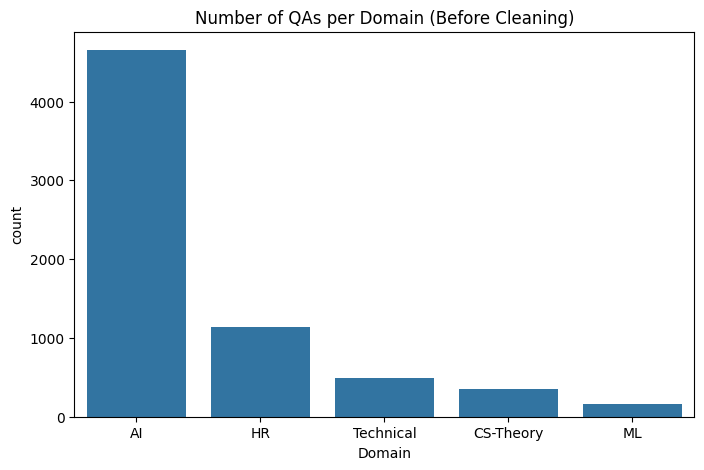

In [ ]:
# ---- Load Datasets ----
def load_datasets():
    dfs = []

    # ML
    ml_df = pd.DataFrame(load_dataset("manasuma/ml_interview_qa")['train'])
    ml_df.rename(columns={'Questions':'Question','Answers':'Answer'}, inplace=True)
    ml_df['Domain'] = 'ML'
    dfs.append(ml_df)

    # AI
    ai_df = pd.DataFrame(load_dataset("K-areem/AI-Interview-Questions")['train'])
    def split_ai(text):
        match = re.match(r"<s>\[INST\](.*?)\[/INST\](.*?)</s>", text, re.DOTALL)
        if match: return pd.Series([match.group(1).strip(), match.group(2).strip()])
        return pd.Series([text, ""])
    ai_df[['Question','Answer']] = ai_df['text'].apply(split_ai)
    ai_df['Domain'] = 'AI'
    dfs.append(ai_df[['Question','Answer','Domain']])

    # HR
    hr_df = pd.DataFrame(load_dataset("Bhavya-123/HRMS_Datahub")['train'])
    hr_df.rename(columns={'question':'Question','answer':'Answer'}, inplace=True)
    hr_df['Domain'] = 'HR'
    dfs.append(hr_df)

    # Technical
    tech_df = pd.DataFrame(load_dataset("Aiman1234/Interview-questions")['train'])
    tech_df.rename(columns={'Questions':'Question','Answers':'Answer'}, inplace=True)
    tech_df['Domain'] = 'Technical'
    dfs.append(tech_df)

    # CS-Theory
    import requests
    url = "https://huggingface.co/datasets/rohanrdy/CS-Theory-QA-Dataset/resolve/main/intents.json"
    data = requests.get(url).json()
    qa_list = []
    for item in data.get('intents', []):
        for q in item.get('patterns', []):
            a = item.get('responses', ["No answer"])[0]
            qa_list.append({'Question': q.strip(), 'Answer': a.strip(), 'Domain': 'CS-Theory'})
    cs_df = pd.DataFrame(qa_list)
    dfs.append(cs_df)

    combined = pd.concat(dfs, ignore_index=True)
    return combined

# Load
raw_df = load_datasets()
print("Raw dataset shape:", raw_df.shape)
print(raw_df.head())

# Visualization before cleaning
plt.figure(figsize=(8,5))
sns.countplot(data=raw_df, x='Domain', order=raw_df['Domain'].value_counts().index)
plt.title("Number of QAs per Domain (Before Cleaning)")
plt.show()


Cleaned dataset shape: (5302, 9)
                                            Question  \
0  difference between supervised and unsupervised...   
1  what is reinforcment learning and how would yo...   
2                            what is deep learning ?   
3  difference between machine learning and deep l...   
4              difference between bias and variance?   

                                              Answer Domain  Tag Subtag  \
0  supervised learning is when you know the outco...     ML  NaN    NaN   
1  a learning differs from supervised learning in...     ML  NaN    NaN   
2  deep learning is defined as algorithms inspire...     ML  NaN    NaN   
3  since dl is a subset of ml and both being subs...     ML  NaN    NaN   
4  bias is definned as over simpliciation assumpt...     ML  NaN    NaN   

   Number language  level  Unnamed: 5  
0     NaN      NaN     NaN        NaN  
1     NaN      NaN     NaN        NaN  
2     NaN      NaN     NaN        NaN  
3     NaN      NaN 

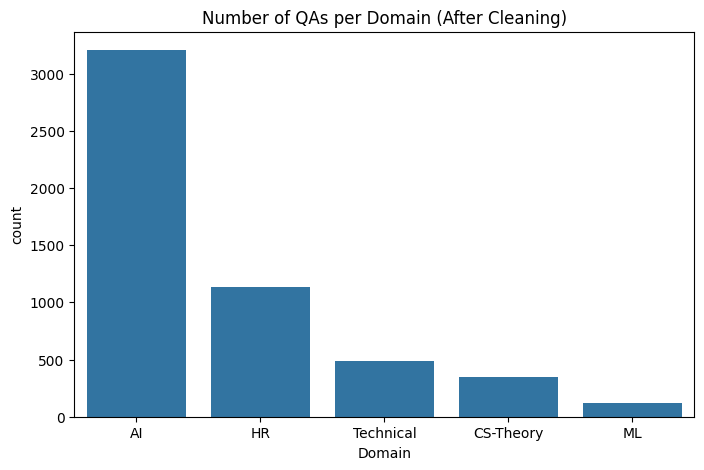

In [ ]:
# ---- Cleaning ----
clean_df = raw_df.copy()
clean_df['Question'] = clean_df['Question'].apply(clean_text)
clean_df['Answer'] = clean_df['Answer'].apply(clean_text)
clean_df = clean_df[(clean_df['Question'] != "") & (clean_df['Answer'] != "")]
clean_df = clean_df[~clean_df['Answer'].apply(is_link)]
clean_df.drop_duplicates(inplace=True)
clean_df.reset_index(drop=True, inplace=True)

print("Cleaned dataset shape:", clean_df.shape)
print(clean_df.head())

# Visualization after cleaning
plt.figure(figsize=(8,5))
sns.countplot(data=clean_df, x='Domain', order=clean_df['Domain'].value_counts().index)
plt.title("Number of QAs per Domain (After Cleaning)")
plt.show()


In [ ]:
clean_df = clean_df[['Question', 'Answer', 'Domain']].copy()
def remove_special_chars(text):
    text = re.sub(r'\s+', ' ', text)  # multiple spaces/newlines → single space
    text = re.sub(r'[^\w\s?.,]', '', text)  # remove special chars except ?, ., ,
    return text.strip()

clean_df['Question'] = clean_df['Question'].apply(remove_special_chars)
clean_df['Answer'] = clean_df['Answer'].apply(remove_special_chars)
clean_df = clean_df[(clean_df['Question'].str.split().str.len() > 2) &
                    (clean_df['Answer'].str.split().str.len() > 2)].reset_index(drop=True)
clean_df.drop_duplicates(inplace=True)
clean_df.reset_index(drop=True, inplace=True)

print("Cleaned dataset shape:", clean_df.shape)
print(clean_df.head())

# After cleaning your dataset
clean_df['Domain'] = clean_df['Domain'].str.strip().str.upper()



Cleaned dataset shape: (5157, 3)
                                            Question  \
0  difference between supervised and unsupervised...   
1  what is reinforcment learning and how would yo...   
2                            what is deep learning ?   
3  difference between machine learning and deep l...   
4              difference between bias and variance?   

                                              Answer Domain  
0  supervised learning is when you know the outco...     ML  
1  a learning differs from supervised learning in...     ML  
2  deep learning is defined as algorithms inspire...     ML  
3  since dl is a subset of ml and both being subs...     ML  
4  bias is definned as over simpliciation assumpt...     ML  


In [ ]:
def extract_features(df, sbert_model, tfidf_vectorizer=None, fit_vectorizer=True):
    q_emb = sbert_model.encode(df['Question'].tolist(), convert_to_numpy=True)
    a_emb = sbert_model.encode(df['Answer'].tolist(), convert_to_numpy=True)
    cos_sim = np.array([util.cos_sim([q],[a]).item() for q,a in zip(q_emb,a_emb)])

    if fit_vectorizer:
        tfidf_vectorizer = TfidfVectorizer(max_features=5000)
        tfidf_matrix_a = tfidf_vectorizer.fit_transform(df['Answer']).toarray()
        tfidf_matrix_q = tfidf_vectorizer.transform(df['Question']).toarray()
    else:
        tfidf_matrix_a = tfidf_vectorizer.transform(df['Answer']).toarray()
        tfidf_matrix_q = tfidf_vectorizer.transform(df['Question']).toarray()
    tfidf_sim = np.array([np.dot(q,a)/(np.linalg.norm(q)*np.linalg.norm(a)+1e-8) for q,a in zip(tfidf_matrix_q, tfidf_matrix_a)])

    q_len = df['Question'].apply(lambda x: max(1,len(x.split()))).values
    a_len = df['Answer'].apply(lambda x: max(1,len(x.split()))).values
    length_ratio = (a_len / q_len).clip(0,5)

    stopword_ratio = df['Answer'].apply(lambda x: len([w for w in x.split() if w in STOPWORDS])/max(1,len(x.split()))).values
    readability = df['Answer'].apply(lambda x: flesch_reading_ease(x)).values

    X = np.vstack([cos_sim, tfidf_sim, length_ratio, stopword_ratio, readability]).T
    return X, tfidf_vectorizer


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import compute_sample_weight
from collections import Counter

# ---- Generate labels ----
def categorize(cos_sim_score):
    if cos_sim_score >= 0.75: return 3
    elif cos_sim_score >= 0.5: return 2
    elif cos_sim_score >= 0.25: return 1
    else: return 0

# ---- Train Hybrid SVM (SMOTE + Domain weighting) ----
sbert_model = SentenceTransformer(EMBEDDER_MODEL)
X, tfidf_vectorizer = extract_features(clean_df, sbert_model, fit_vectorizer=True)
y = np.array([categorize(s) for s in X[:,0]])

# Compute domain weights
domain_weights = compute_sample_weight(class_weight='balanced', y=clean_df['Domain'])

# Train-test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, domain_weights, test_size=0.2, random_state=42, stratify=y
)

# Dynamic k_neighbors for SMOTE to avoid errors
class_counts = Counter(y_train)
min_samples = min([count for count in class_counts.values() if count > 1])
k_neighbors = max(1, min(5, min_samples - 1))

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train SVM
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train_res, y_train_res)

# Metrics
y_pred = clf.predict(X_test)
print("📊 SVM Metrics (Hybrid - SMOTE + Domain Weighting):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Weighted F1:", f1_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/sentence_transformers/util/tensor.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  a = torch.tensor(a)


📊 SVM Metrics (Hybrid - SMOTE + Domain Weighting):
Accuracy: 0.9660852713178295
Weighted F1: 0.9674113145025875
Confusion Matrix:
 [[  1   0   0   0]
 [  1  23   0   0]
 [  0  11 272   0]
 [  0   0  23 701]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.68      0.96      0.79        24
           2       0.92      0.96      0.94       283
           3       1.00      0.97      0.98       724

    accuracy                           0.97      1032
   macro avg       0.77      0.97      0.85      1032
weighted avg       0.97      0.97      0.97      1032



In [ ]:
def evaluate_answer_svm(user_ans, ref_ans, clf, sbert_model, tfidf_vectorizer):
    q_emb = sbert_model.encode([ref_ans], convert_to_numpy=True)
    a_emb = sbert_model.encode([user_ans], convert_to_numpy=True)
    cos_sim = float(util.cos_sim(q_emb, a_emb).item())

    q_tfidf = tfidf_vectorizer.transform([ref_ans]).toarray()
    a_tfidf = tfidf_vectorizer.transform([user_ans]).toarray()
    tfidf_sim = np.dot(q_tfidf, a_tfidf.T)[0][0] / (np.linalg.norm(q_tfidf)*np.linalg.norm(a_tfidf)+1e-8)

    q_len = max(1,len(ref_ans.split()))
    a_len = max(1,len(user_ans.split()))
    length_ratio = (a_len/q_len)

    stopword_ratio = len([w for w in user_ans.split() if w in STOPWORDS])/max(1,len(user_ans.split()))
    readability = flesch_reading_ease(user_ans)

    X_user = np.array([[cos_sim, tfidf_sim, length_ratio, stopword_ratio, readability]])
    pred_class = clf.predict(X_user)[0]
    pred_proba = clf.predict_proba(X_user)[0]

    feedback_map = {0:"Poor answer. Review the concept.",
                    1:"Average answer. Needs improvement.",
                    2:"Good answer. Minor improvements needed.",
                    3:"Excellent answer!"}

    return pred_class, pred_proba, feedback_map[pred_class]


In [ ]:

import random

# Normalize user input
selected_domain = input("Select a domain: ").strip().upper()

# Filter questions by selected domain
domain_qas = clean_df[clean_df['Domain'] == selected_domain].reset_index(drop=True)

# Keep track of already asked question indices
asked_indices = set()
scores = []

# Number of questions to ask
num_questions = min(5, len(domain_qas))

for _ in range(num_questions):
    # Select a random question index that hasn't been asked
    remaining_indices = list(set(domain_qas.index) - asked_indices)
    if not remaining_indices:
        break
    idx = random.choice(remaining_indices)
    asked_indices.add(idx)

    row = domain_qas.loc[idx]
    print(f"\nQuestion: {row['Question']}")
    user_ans = input("Your Answer: ").strip()

    # Evaluate the answer using SVM
    pred_class, pred_proba, feedback = evaluate_answer_svm(
        user_ans, row['Answer'], clf, sbert_model, tfidf_vectorizer
    )
    print(f"Predicted Quality: {pred_class} | Feedback: {feedback}")
    print(f"Class Probabilities: {pred_proba}")
    scores.append(pred_class)

# Compute overall score
overall = np.mean(scores)
print(f"\nOverall Score (Average Class): {overall:.2f}")



In [ ]:
# Extract features for visualization
X_vis, _ = extract_features(clean_df, sbert_model, tfidf_vectorizer=tfidf_vectorizer, fit_vectorizer=False)
feature_names = ['Cosine_Sim', 'TFIDF_Sim', 'Length_Ratio', 'Stopword_Ratio', 'Readability']

# Add to DataFrame for easy plotting
features_df = pd.DataFrame(X_vis, columns=feature_names)

# Add synthetic labels (based on cosine similarity)
features_df['Quality_Label'] = [categorize(s) for s in X_vis[:,0]]

# Pairplot for feature relationships
sns.pairplot(features_df, hue='Quality_Label', palette='Set2', diag_kind='kde')
plt.suptitle("Feature Distributions Before SVM Training", y=1.02)
plt.show()

# Boxplots for each feature by label
plt.figure(figsize=(15,8))
for i, col in enumerate(feature_names):
    plt.subplot(2,3,i+1)
    sns.boxplot(x='Quality_Label', y=col, data=features_df, palette='Set3')
    plt.title(f"{col} by Quality Label")
plt.tight_layout()
plt.show()


In [ ]:
# ---- Predict labels using trained SVM ----
y_pred = clf.predict(X_vis)  # X_vis is your feature matrix
features_df['Predicted_Label'] = y_pred

# ---- Pairplot for feature relationships after SVM ----
sns.pairplot(features_df, hue='Predicted_Label', palette='Set1', diag_kind='kde')
plt.suptitle("Feature Distributions After SVM Classification", y=1.02)
plt.show()

# ---- Boxplots for each feature by predicted label ----
plt.figure(figsize=(15,8))
for i, col in enumerate(feature_names):
    plt.subplot(2,3,i+1)
    sns.boxplot(x='Predicted_Label', y=col, data=features_df, palette='Set2')
    plt.title(f"{col} by Predicted Label")
plt.tight_layout()
plt.show()
